# JDOT Domain Adaptation with Gaussian Distributions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.svm import SVC, LinearSVC
from sklearn import preprocessing
import ot

In [2]:
colormap = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

## Create the dataset

In [3]:
lb = preprocessing.LabelBinarizer()

### Source domain

In [4]:
N_source = [50, 50, 50] # number of points for the 2 classes

In [5]:
mean = 1*np.array([[-1,-1], [-1,1], [1,0]])
std = 0.1

In [6]:
X = []
X_source = np.concatenate([ot.datasets.get_2D_samples_gauss(N_source[i], mean[i], std) 
                           for i in range(len(N_source))], axis=0)

Y_source = np.concatenate([[i]*N_source[i] for i in range(len(N_source))])
Y_source_bin = lb.fit_transform(Y_source)

### Target domain

In [7]:
N_target = [50, 50, 50] # number of points for the 2 classes

In [8]:
angle = np.pi/4
rot_matrix = np.array([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])
mean = np.dot(rot_matrix, mean.T).T
std = 0.1

In [9]:
X = []
X_target = np.concatenate([ot.datasets.get_2D_samples_gauss(N_target[i], mean[i], std) 
                           for i in range(len(N_target))], axis=0)

Y_target = np.concatenate([[i]*N_target[i] for i in range(len(N_target))])
Y_target_bin = lb.fit_transform(Y_target)

### Label binarization

### Display the dataset

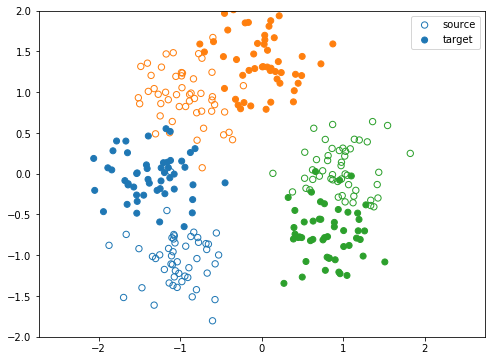

In [10]:
plt.rcParams['figure.figsize'] = (8, 6)
plt.axis("equal")
plt.axis([-2,2,-2,2])

plt.scatter(X_source[:,0], X_source[:,1], label="source", s=40, facecolors='none', edgecolor=colormap[Y_source])
plt.scatter(X_target[:,0], X_target[:,1], label="target", color=colormap[Y_target])
plt.legend()

## Initialization

### Model for the classifier

In [11]:
model = LinearSVC()

In [12]:
model.fit(X_source, Y_source)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

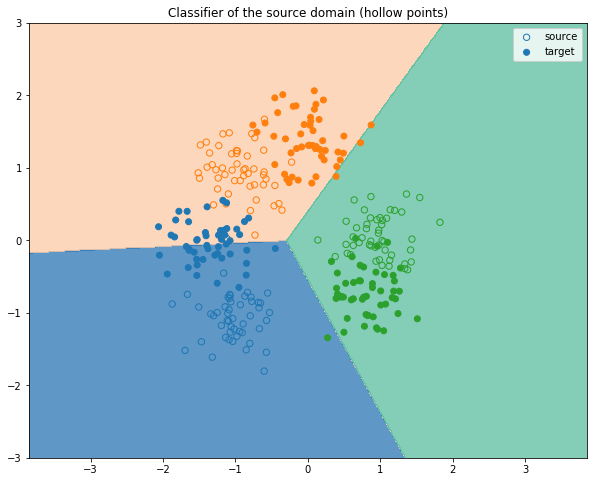

In [13]:
from matplotlib import colors

plt.rcParams['figure.figsize'] = (10, 8)
plt.axis("equal")
plt.axis(3*np.array([-1,1,-1,1]))

x_min, x_max = -4, 4
y_min, y_max = -4, 4
h = 0.01
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

cm = colors.ListedColormap([plt.cm.Set1(1), plt.cm.Pastel2(1), plt.cm.Set2(0)])
Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
cont = plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)

plt.title("Classifier of the source domain (hollow points)")
plt.scatter(X_source[:,0], X_source[:,1], label="source", s=40, facecolors='none', edgecolor=colormap[Y_source])
plt.scatter(X_target[:,0], X_target[:,1], label="target", color=colormap[Y_target])
plt.legend()

In [14]:
def f(x):
    return model.predict(x.reshape(1,2)).flatten()

### Label loss function

In [15]:
def label_loss(y, fx):
    if len(fx) == 1:
        fx = lb.transform(fx)
    fx = fx.flatten()
    return np.sum([y[i_class] * (1-fx[i_class])**2 + (1 - y[i_class]) * (-1 - fx[i_class])**2 
                   for i_class in range(len(y))])

### Hyperparameters

In [22]:
alpha = 1

a = np.ones((len(Y_source),)) / len(Y_source)
b = np.ones((len(Y_target),)) / len(Y_target)

## Run the algorithm

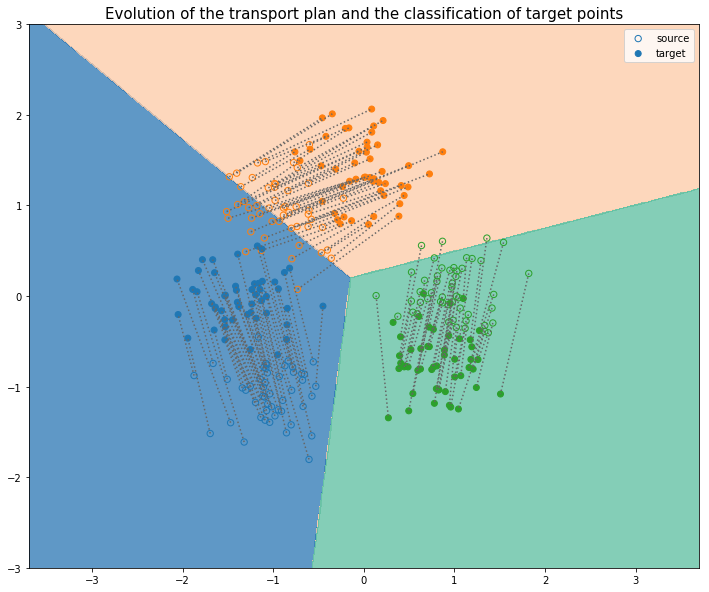

In [21]:
plt.rcParams['figure.figsize'] = (12, 10)
plt.axis("equal")
plt.axis(3*np.array([-1,1,-1,1]))

nb_iter = 1

for i in range(nb_iter):
    # Gamma part: learn a transport plan
    D = np.array([[np.linalg.norm(xs-xt) for xt in X_target] for xs in X_source])
    L = np.array([[label_loss(ys, f(xt)) for xt in X_target] for ys in Y_source_bin])
    C = alpha * D + L
    gamma = ot.emd(a, b, C)
   
    # f part: learn 
    Y_hat = len(Y_source) * gamma.T.dot(Y_source)
    Y_hat_bin = (1. / len(Y_source)) * np.dot(gamma.T, Y_source_bin)
    Y_hat = lb.inverse_transform(Y_hat_bin)
    model.fit(X_target, Y_hat)
    
    # Plot
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    cont = plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    plt.scatter(X_source[:,0], X_source[:,1], label="source", s=40, facecolors='none', edgecolor=colormap[Y_source])
    plt.scatter(X_target[:,0], X_target[:,1], label="target", color=colormap[Y_hat])
    ot.plot.plot2D_samples_mat(X_source, X_target, gamma, color=plt.cm.Dark2(8), linestyle=":")
    plt.title("Evolution of the transport plan and the classification of target points", fontsize=15)
    plt.legend()
    
    #plt.savefig("screenshots/gaussian-13.png")

## Interesting information

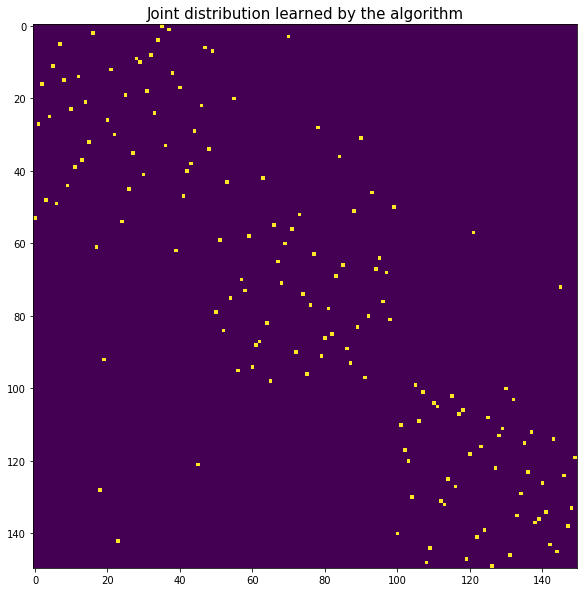

In [18]:
gamma = ot.emd(a, b, C)
plt.imshow(gamma, interpolation='nearest')
plt.title("Joint distribution learned by the algorithm", fontsize=15)